In [1]:
%load_ext autoreload
%autoreload 2
%load_ext autotime
%matplotlib inline

# AutoEncoders 101 

Some notes that I put together on AutoEncoders in my attempts to better understand them followed by a PyTorch implementation. 

AutoEncoders typically have a hidden layer $h$ that represents the input vector $\textbf{x}$. Autoencoders consist of two parts, an encoder that models $h = f(x)$ and a decoder that produces a reconstruction $r = g(h)$. AutoEncoders are trained in the hope that $h$ will take on a useful representation of the training data and are therefore usually restricted in some way to prevent the decoder from learning to perfectly reconstruct the input. 

AutoEncoders are trained to minimize a loss objective such as

$$
L(x, g(f(x)))
$$

Where L is a loss function such as cross entropy loss. 

## Denoising AutoEncoders (DAEs)

Denoising AutoEncoders are very similar to AutoEncoders with a slight variation to the loss function: 

$$
L(x, g(f(\tilde{x})))
$$

where $\tilde{x}$ is a copy of $\textbf{x}$ that has undergone some sort of perturbation to corrupt the copy. This introduces noise to the training data and helps to prevent the autoencoder from learning the identity function.

Not covered are under/over complete AutoEncoders and other variations. 

# Torch Implementation

That's enough theory, below is an implementation of DAE, VAE and AAE using the MNIST dataset. 


In [2]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
from scipy.stats import norm



time: 653 ms


## Initialize the DataLoaders

Fortunately the MNIST dataset is included with torchvision so iterators can be easily constructed. 

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../data', train=False, 
                   transform=transforms.ToTensor()),
    batch_size=16, shuffle=True)


time: 33.9 ms


### Transform to add Gaussian Noise

Found this [here](https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745)

In [4]:
class AddGaussianNoise:
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

time: 1.19 ms


## Define the AutoEncoders

We'll just use feedforward layers for the encoder and decoder to keep things simple. 

In [5]:
class AutoEncoder(nn.Module):
    """AutoEncoder."""
    def __init__(self, img_size, encoder_dim, z_dim, noise_machine=None):
        """Initialization."""
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(img_size, encoder_dim),
            nn.ReLU(),
            nn.Linear(encoder_dim, z_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, encoder_dim),
            nn.ReLU(),
            nn.Linear(encoder_dim, img_size)
        )
        
        self.noise_machine = noise_machine
        
    def encode(self, x):
        x = x.view(-1, 784)
        if self.noise_machine:
            x = self.noise_machine(x)
        return self.encoder(x)
    
    def decode(self, z):
        return torch.sigmoid(self.decoder(z))
        
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z, _, _
    
    def __repr__(self):
        if self.noise_machine:
            return f"Denoising{self.__class__.__name__}"
        return self.__class__.__name__
        
    @staticmethod
    def loss_function(recon_x, x, mu, logvar, z):
        return F.binary_cross_entropy(recon_x, x.view(-1, 784), 
                                      reduction='sum')

time: 2.53 ms


## Create the training/testing routines

Create a simple training class to handle the training and testing of the various autoencoders.

In [6]:
class AutoEncoderTrainer:
    """AutoEncoder Training class."""
    def __init__(self, model, optimizer, train_loader, test_loader): 
        """Initialization."""
        self.model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else
                                   "cpu")
        self.optimizer = optimizer(self.model.parameters(), lr=1e-3)
        self.train_loader = train_loader
        self.test_loader = test_loader
        
    def train_iter(self):
        """Single pass through the training data."""
        self.model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(self.train_loader):
            data = data.to(self.device)
            self.optimizer.zero_grad()
            logits, z, mu, logvar = self.model(data)
            loss = self.model.loss_function(logits, data, mu, logvar, z)
            loss.backward()
            train_loss += loss.item()
            self.optimizer.step()
        
        return train_loss / len(self.train_loader.dataset)
    
    def test_iter(self):
        """Single pass through the test set."""
        self.model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (data, _) in enumerate(self.test_loader):
                data = data.to(self.device)
                logits, z, mu, logvar = self.model(data)
                test_loss += self.model.loss_function(
                    logits, data, mu, logvar, z).item()

        return test_loss / len(self.test_loader.dataset)
    
    def train_and_evaluate(self, epochs):
        """Run training and evaluation."""
        self.model.to(self.device)
        test_losses = []
        print(f"Training: {self.model.__repr__()}")
        for epoch in range(epochs):
            train_loss = self.train_iter()
            test_losses.append(self.test_iter())
            
            print(f"\tEpoch: {epoch}, Train Loss: {train_loss:.4f}," 
                  f"Test Loss: {test_losses[-1]:.4f}")

time: 3.6 ms


## Train the Models 

Create the models and trainers and run training.

In [7]:
ae = AutoEncoder(784, 400, 2)
dae = AutoEncoder(784, 400, 2, AddGaussianNoise())
ae_trainer = AutoEncoderTrainer(ae, optim.Adam, train_loader, test_loader)
dae_trainer = AutoEncoderTrainer(dae, optim.Adam, train_loader, test_loader)

time: 9.74 ms


In [8]:
ae_trainer.train_and_evaluate(10)
dae_trainer.train_and_evaluate(10)

Training: AutoEncoder
	Epoch: 0, Train Loss: 162.5022,Test Loss: 152.5002
	Epoch: 1, Train Loss: 150.0208,Test Loss: 148.1652
	Epoch: 2, Train Loss: 146.5502,Test Loss: 145.6302
	Epoch: 3, Train Loss: 144.6135,Test Loss: 143.9060
	Epoch: 4, Train Loss: 143.2506,Test Loss: 143.1040
	Epoch: 5, Train Loss: 142.2494,Test Loss: 141.8992
	Epoch: 6, Train Loss: 141.3925,Test Loss: 141.6778
	Epoch: 7, Train Loss: 140.7622,Test Loss: 140.8637
	Epoch: 8, Train Loss: 140.1165,Test Loss: 140.5217
	Epoch: 9, Train Loss: 139.6627,Test Loss: 140.3074
Training: DenoisingAutoEncoder
	Epoch: 0, Train Loss: 178.3038,Test Loss: 171.1260
	Epoch: 1, Train Loss: 170.1141,Test Loss: 168.2936
	Epoch: 2, Train Loss: 168.0553,Test Loss: 166.8499
	Epoch: 3, Train Loss: 166.8636,Test Loss: 165.6199
	Epoch: 4, Train Loss: 166.2499,Test Loss: 164.9761
	Epoch: 5, Train Loss: 165.7199,Test Loss: 164.6165
	Epoch: 6, Train Loss: 165.2229,Test Loss: 164.5754
	Epoch: 7, Train Loss: 164.8971,Test Loss: 164.3402
	Epoch: 8, 

It's interesting but unsurprising that the loss of both denoising models is worse. It's hard to evaluate the benefits of adding noise in this toy case, the manifolds plotted below don't appear to be any smoother.

Also by locking the hidden dimension (z) to 2 we degrade performance so that we can generate the manifolds below. 

More complex Encoders/Decoders and a higher dimension for z should yield much better results.

## Plot the manifold

Found this code online somehwere (Kaggle I think.). If we set the hidden dimension (z) to be 2 we can construct a 2D Gaussian manifold to show how the hidden layer represents the various digits in the MNIST dataset. 

Below I've plotted the manifold for each model. 

In [9]:
def plot_manifold(model, n=20, digit_size=28):
    figure = np.zeros((digit_size * n, digit_size * n))

    # Construct grid of latent variable values
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    # decode for each square in the grid
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            z_sample = torch.from_numpy(
                np.tile(z_sample, 16).reshape(16, 2).astype(np.float32))
            x_decoded = model.decode(z_sample).detach().numpy()
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gnuplot2')
    plt.show()  

time: 3.31 ms


### AutoEncoder Manifold


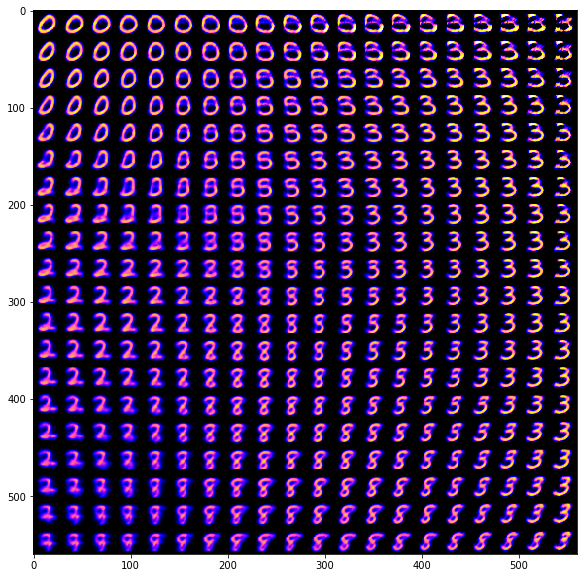

time: 453 ms


In [11]:
plot_manifold(ae_trainer.model)

### Denoising AutoEncoder Manifold


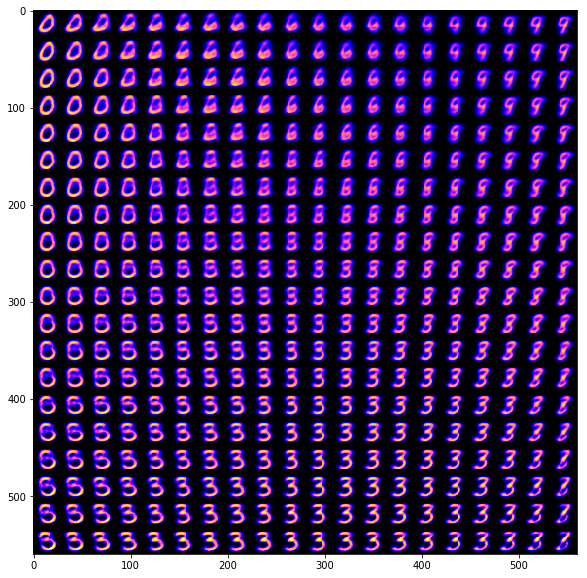

time: 365 ms


In [12]:
plot_manifold(dae_trainer.model)